In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models


### Constantes

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

### Funções auxiliares

In [3]:
def image_and_breed(objecto):
  print(objecto)
  return (objecto['image'], objecto['species'])

def central_crop(image):
  s = tf.shape(image)
  L = tf.reduce_min((s[0], s[1]))
  x1 = (s[1] - L ) // 2
  y1 = (s[0] - L ) // 2

  return tf.image.resize(image[y1: y1+L, x1: x1+L], (IMAGE_SIZE, IMAGE_SIZE))


def preprocess_aug_mobileNet(image, label):

  print(label)

  image = central_crop(image) # Crop da imagem

  image = tf.cast(image, tf.uint8)
  image = tf.image.random_brightness(image, max_delta=0.3) # Brilho random
  #image = tf.image.random_contrast(image, lower=1, upper=1.5) # Contrast random

  image = tf.cast(image, tf.float32)
  if (tf.random.uniform((), minval=0, maxval=1) < 0.1): # Conversão para gray scale random
    image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])

  image = tf.image.random_flip_left_right(image) # Random flip vertical
  image = tf.image.random_flip_up_down(image) # Random flip horizontal

  image = tf.keras.applications.mobilenet_v2.preprocess_input(image) # Preprocess MobileNetV2

  return image, label # Retorno da imagem e classe



def preprocess_mobileNet(image, label):

  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) # Redimensionamento da imagem
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image) # Preprocess MobileNetV2

  return image, label # Retorno da imagem e classe



def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(accuracy))

  plt.plot(epochs, loss, color='blue', linestyle='--', label='training_loss')
  plt.plot(epochs, accuracy, color='blue', label='training_accuracy')
  plt.plot(epochs, val_loss, color='orange', linestyle='--', label='validation_loss')
  plt.plot(epochs, val_accuracy, color='orange', label='validation_accuracy')
  plt.axis([0,NUM_EPOCHS,0,2])
  plt.title("Train and Test Evolution")
  plt.xlabel("Epochs")
  plt.legend()

## Load Dataset

In [4]:
(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    name = 'oxford_iiit_pet',
    split = ["train[:80%]", "train[80%:]", "test"],
    with_info = True,
    as_supervised = False
)

In [5]:
class_names = ds_info.features['label'].names
specie_names = ds_info.features['species'].names

### Prepare datasets

In [6]:
ds_train = ds_train.map(image_and_breed).map(preprocess_aug_mobileNet).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_valid = ds_valid.map(image_and_breed).map(preprocess_mobileNet).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(image_and_breed).map(preprocess_mobileNet).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

{'file_name': <tf.Tensor 'args_0:0' shape=() dtype=string>, 'image': <tf.Tensor 'args_1:0' shape=(None, None, 3) dtype=uint8>, 'label': <tf.Tensor 'args_2:0' shape=() dtype=int64>, 'segmentation_mask': <tf.Tensor 'args_3:0' shape=(None, None, 1) dtype=uint8>, 'species': <tf.Tensor 'args_4:0' shape=() dtype=int64>}
Tensor("args_1:0", shape=(), dtype=int64)
{'file_name': <tf.Tensor 'args_0:0' shape=() dtype=string>, 'image': <tf.Tensor 'args_1:0' shape=(None, None, 3) dtype=uint8>, 'label': <tf.Tensor 'args_2:0' shape=() dtype=int64>, 'segmentation_mask': <tf.Tensor 'args_3:0' shape=(None, None, 1) dtype=uint8>, 'species': <tf.Tensor 'args_4:0' shape=() dtype=int64>}
{'file_name': <tf.Tensor 'args_0:0' shape=() dtype=string>, 'image': <tf.Tensor 'args_1:0' shape=(None, None, 3) dtype=uint8>, 'label': <tf.Tensor 'args_2:0' shape=() dtype=int64>, 'segmentation_mask': <tf.Tensor 'args_3:0' shape=(None, None, 1) dtype=uint8>, 'species': <tf.Tensor 'args_4:0' shape=() dtype=int64>}


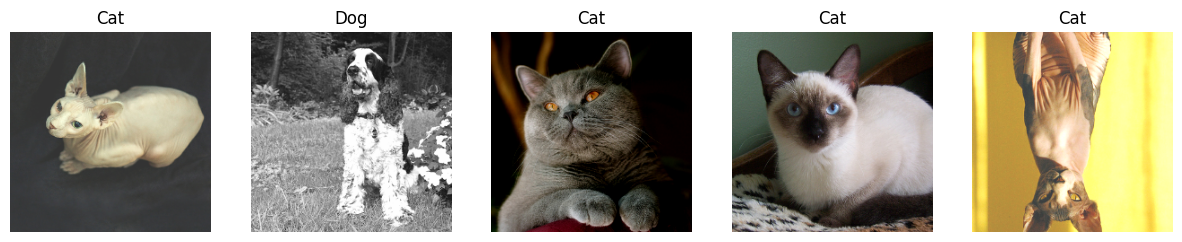

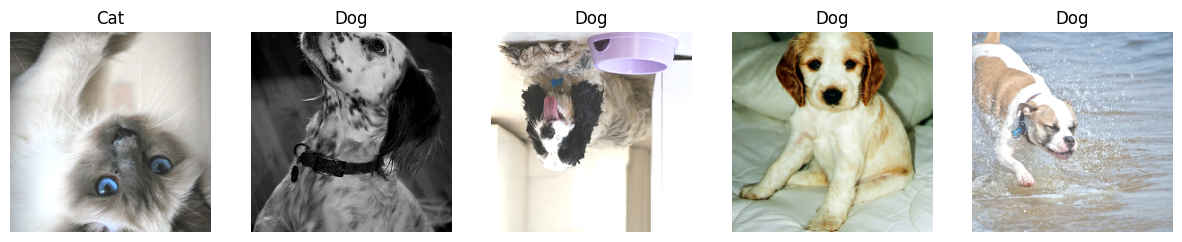

In [7]:
nBatches = 2
firstNImages = 5
for Img, lab in ds_train.take(nBatches):
  plt.figure(figsize=(15, 3))
  for i in range(firstNImages):
    ax = plt.subplot(1, 5, i+1)
    ax.set_title(ds_info.features['species'].names[lab[i]])
    A = (Img[i].numpy() +1)/2 *255.
    plt.imshow(A.astype('uint8'))
    plt.axis('off')
  print("\n\n")

____________________________

# Prepare model using Mobile Net V2 as base model

In [8]:
def build_mobilenetv2_model():
  base_model = tf.keras.applications.MobileNetV2(
      input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
      include_top = False,
      weights = "imagenet"
  )

  base_model.trainable = False

  model = models.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  return model

In [9]:
mobilenetv2_model = build_mobilenetv2_model()
mobilenetv2_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ["accuracy"]
)

In [10]:
mobilenetv2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2422081 (9.24 MB)
Trainable params: 164097

_____________________________________

## Fit Model

In [11]:
ds_valid.take(1)


<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [12]:
%%time

import os

NUM_EPOCHS = 30
STEPS_PER_EPOCH = len(ds_train)
VALIDATION_STEPS = len(ds_valid)

best_model = os.path.join('./models/', 'bin_model.keras')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              min_delta=0.001,
                                              restore_best_weights=True)

save_best_model = tf.keras.callbacks.ModelCheckpoint(best_model,
                                             monitor='val_loss',
                                             save_best_only=True)

mobileNet_history = mobilenetv2_model.fit(ds_train,
                                        epochs= NUM_EPOCHS,
                                        steps_per_epoch = STEPS_PER_EPOCH,
                                        validation_data = ds_valid,
                                        validation_steps = VALIDATION_STEPS,
                                        callbacks=[early_stop, save_best_model]
                                        )

Epoch 1/30
92/92 [==============================] - 165s 2s/step - loss: 0.2016 - accuracy: 0.9253 - val_loss: 0.0416 - val_accuracy: 0.9918
Epoch 2/30
92/92 [==============================] - 161s 2s/step - loss: 0.1334 - accuracy: 0.9514 - val_loss: 0.0316 - val_accuracy: 0.9891
Epoch 3/30
92/92 [==============================] - 160s 2s/step - loss: 0.0983 - accuracy: 0.9606 - val_loss: 0.0307 - val_accuracy: 0.9891
Epoch 4/30
92/92 [==============================] - 148s 2s/step - loss: 0.0970 - accuracy: 0.9671 - val_loss: 0.0312 - val_accuracy: 0.9932
Epoch 5/30
92/92 [==============================] - 161s 2s/step - loss: 0.0845 - accuracy: 0.9650 - val_loss: 0.0215 - val_accuracy: 0.9946
Epoch 6/30
92/92 [==============================] - 166s 2s/step - loss: 0.0643 - accuracy: 0.9766 - val_loss: 0.0218 - val_accuracy: 0.9932
Epoch 7/30
92/92 [==============================] - 164s 2s/step - loss: 0.0740 - accuracy: 0.9711 - val_loss: 0.0255 - val_accuracy: 0.9905
Epoch 8/30
92

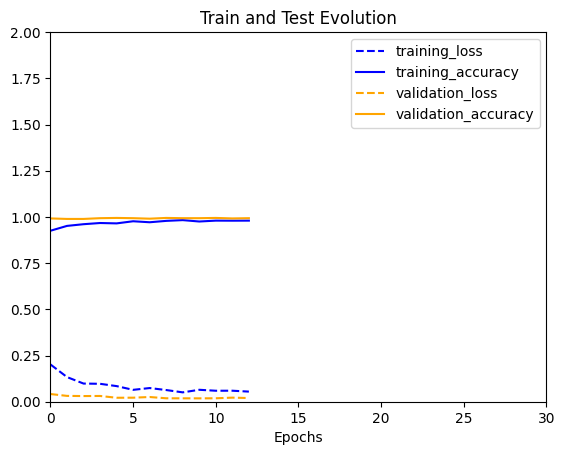

In [13]:
plot_loss_curves(mobileNet_history)

______________
## Evaluate Model

In [14]:
%%time
from sklearn.metrics import classification_report, confusion_matrix

pred = mobilenetv2_model.predict(ds_test)

115/115 [==============================] - 150s 1s/step
CPU times: user 2min 45s, sys: 1min 15s, total: 4min
Wall time: 2min 30s


In [15]:
images = np.concatenate([x for x, y in ds_test], axis=0)
y_true = np.concatenate([y for x, y in ds_test], axis=0)

In [29]:
y_pred = np.where(pred > 0.67, 1, 0).squeeze()
cm = confusion_matrix(y_true, y_pred)

In [30]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# ROC curve
fpr, tpr, _ = roc_curve(y_true, pred)
roc_auc = auc(fpr, tpr)

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, pred)
pr_auc = auc(recall, precision)

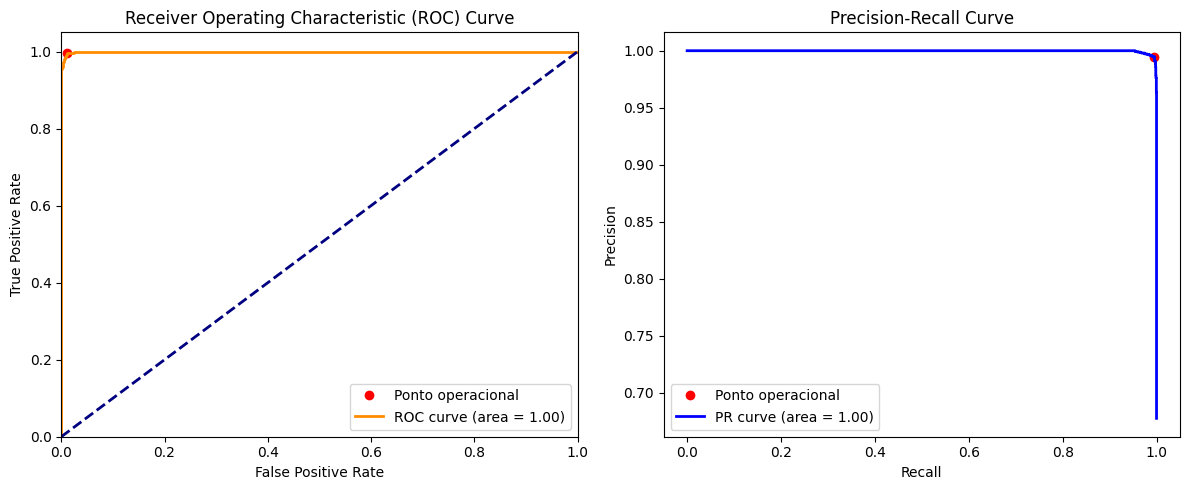

In [31]:
plt.figure(figsize=(12, 5))

fp = cm[0, 1] / (cm[0, 1] + cm[0, 0])
tp = cm[1, 1] / (cm[1, 1] + cm[1, 0])
prec = cm[1, 1] / (cm[1, 1] + cm[0, 1])
rec = cm[1, 1] / (cm[1, 1] + cm[1, 0])

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fp,tp,'or', label='Ponto operacional')
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(rec,prec,'or', label='Ponto operacional')
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


Total number of errors: 24 


Classification Report:
               precision    recall  f1-score   support

         Cat       0.99      0.99      0.99      1183
         Dog       0.99      1.00      1.00      2486

    accuracy                           0.99      3669
   macro avg       0.99      0.99      0.99      3669
weighted avg       0.99      0.99      0.99      3669
 




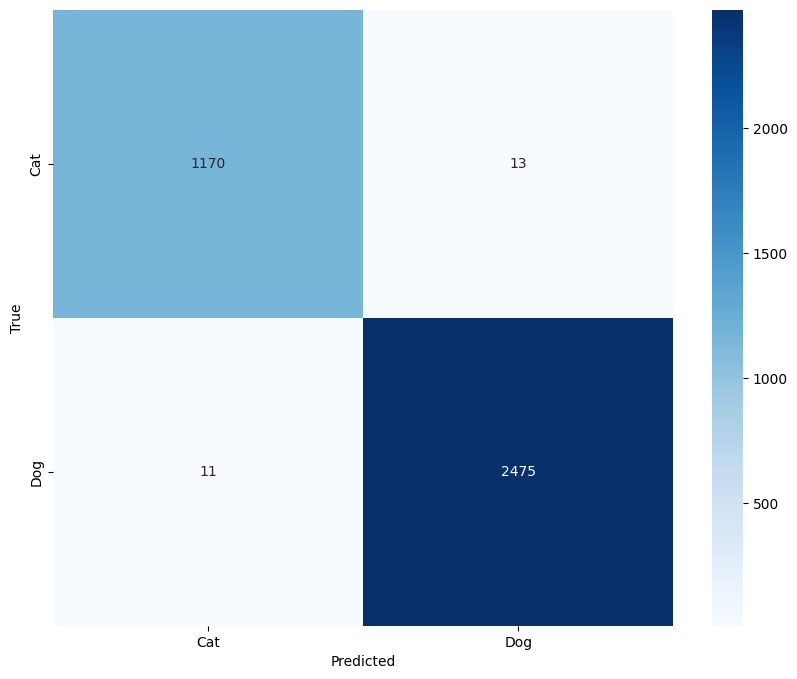

In [32]:
print('Total number of errors:', np.sum(y_true != y_pred), "\n\n")

# Classification report for precision, recall, and F1-score
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=specie_names), "\n\n")

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=specie_names, yticklabels=specie_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Show a few examples of miss classificated images

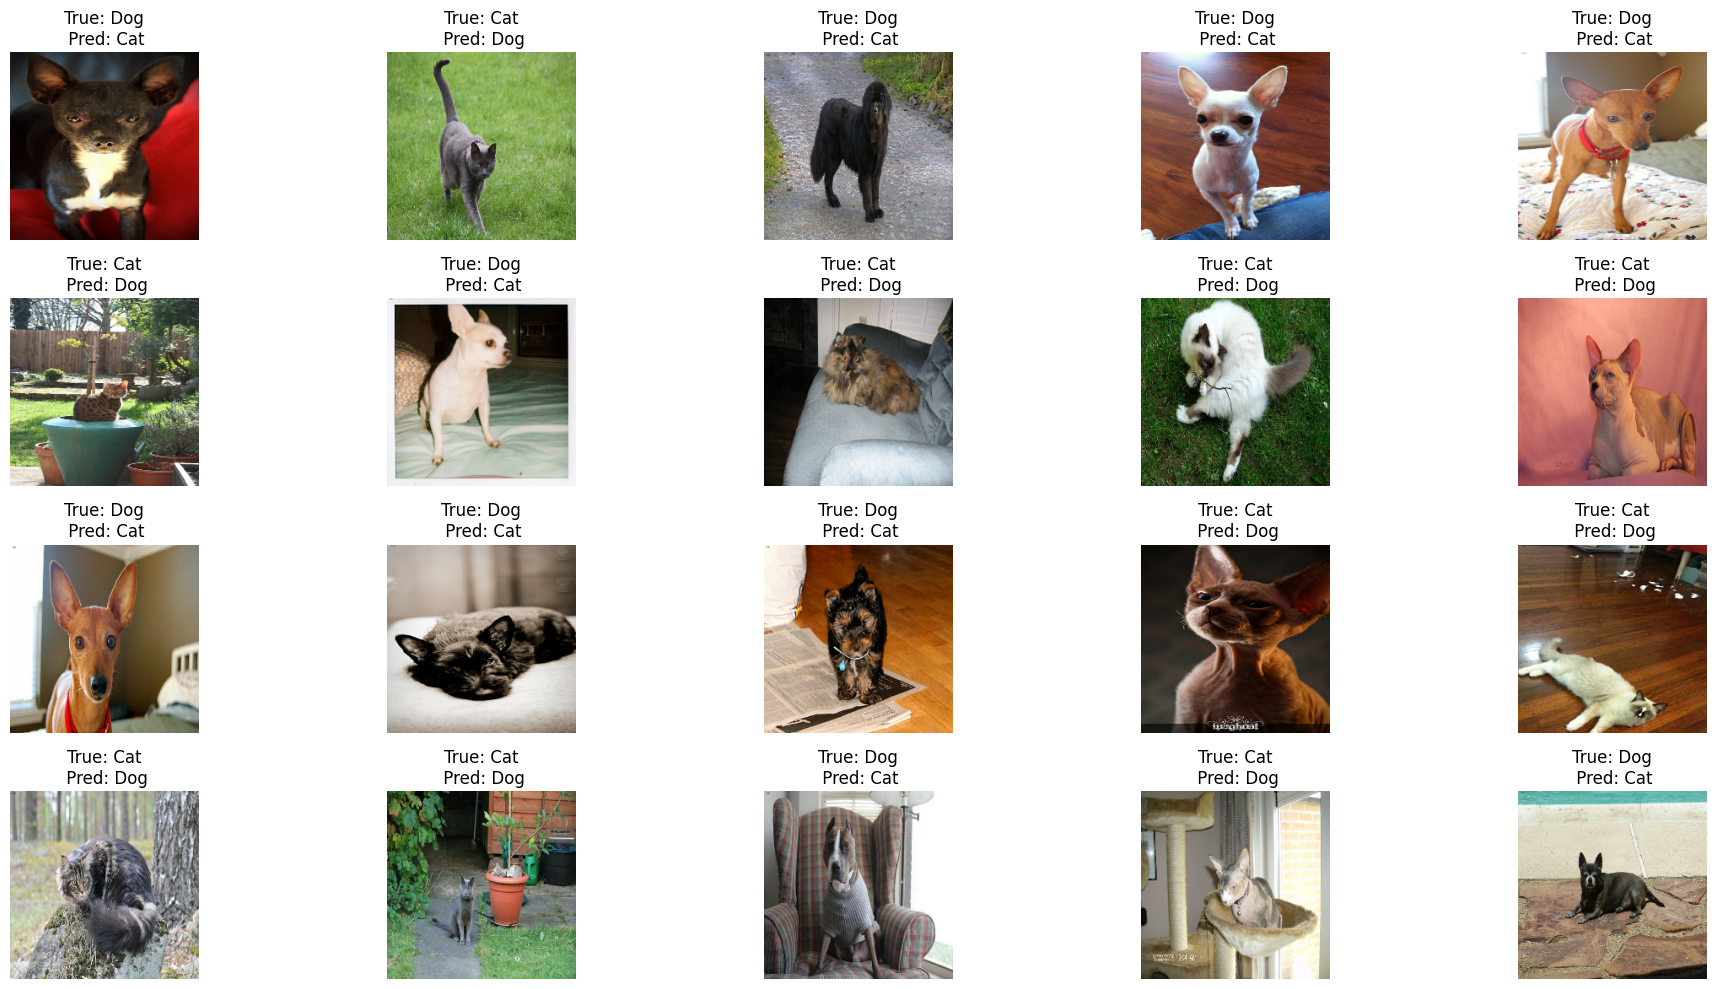

In [33]:
misclassified_indices = np.where(y_true != y_pred)[0]

# Plot misclassified images
num_images_to_plot = 20
plt.figure(figsize=(20, 10))
for i, idx in enumerate(misclassified_indices[:num_images_to_plot]):
  plt.subplot(4, num_images_to_plot//4, i+1)
  image = ((images[idx] + 1)/2 * 255).astype(np.uint8)
  plt.imshow(image)
  plt.title(f'True: {specie_names[y_true[idx]]}\n Pred: {specie_names[y_pred[idx]]}')
  plt.axis('off')

plt.tight_layout()
plt.show()
